In [1]:
import matplotlib.pyplot as plt
import numpy as np
import emachine as EM
import itertools
from sklearn.model_selection import train_test_split

In [2]:
np.random.seed(0)

In [3]:
n_var = 20 ; g = 0.5 ; n_seq = 20000  # will use only 10k for training and 10k for testing

In [4]:
# Synthetic data are generated by using `generate_seq`.
w_true,seqs_train_test = EM.generate_seq(n_var,n_seq,g=g)

seqs,seqs_test = train_test_split(seqs_train_test,test_size=0.5,shuffle=True)
print(seqs.shape,seqs_test.shape)


ops = EM.operators(seqs)
ops_test = EM.operators(seqs_test)
print(ops.shape,ops_test.shape)

(10000, 20) (10000, 20)
(10000, 210) (10000, 210)


In [5]:
# predict interactions w
eps_list = np.linspace(0.1,0.9,9)
n_eps = len(eps_list)
#res = Parallel(n_jobs = n_eps)(delayed(EM.fit)(ops,eps=eps,max_iter=100) for eps in eps_list)
#w_eps = np.array([res[i][0] for i in range(len(res))])
#e_eps = np.array([res[i][1] for i in range(len(res))])

e_eps = np.zeros(len(eps_list))
w_eps = np.zeros((len(eps_list),ops.shape[1]))
for i,eps in enumerate(eps_list):
    w_eps[i,:],e_eps[i] = EM.fit(ops,eps=eps,max_iter=100)
    #print('eps and e_eps:',eps,e_eps[i])

eps: 0.1
eps: 0.2
eps: 0.30000000000000004
eps: 0.4
eps: 0.5
eps: 0.6
eps: 0.7000000000000001
eps: 0.8
eps: 0.9


In [6]:
# energy as function of eps
energy = -ops.dot(w_eps.T)
energy_av = energy.mean(axis=0)

In [7]:
# all possible configurations
seq_all = np.asarray(list(itertools.product([1.0, -1.0], repeat=n_var)))
n_possibles = seq_all.shape[0]
print('number of possible configs:',n_possibles)
print(seq_all.shape)

ops_all = EM.operators(seq_all)
print(ops_all.shape)

# logZ
energy_all = -ops_all.dot(w_eps.T)
prob_all = np.exp(-energy_all)
logZ = np.log(prob_all.sum(axis=0))

number of possible configs: 1048576
(1048576, 20)
(1048576, 210)


In [8]:
# Kullback-Leibler Divergence 
D_KL = energy_av + logZ

In [9]:
# MSE
MSE = ((w_true[np.newaxis,:] - w_eps)**2).mean(axis=1)

In [10]:
# logZ_true
energy_all_true = -ops_all.dot(w_true.T)
prob_all_true = np.exp(-energy_all_true)
logZ_true = np.log(prob_all_true.sum(axis=0))
print('logZ_true:',logZ_true)

logZ_true: 15.203385326641719


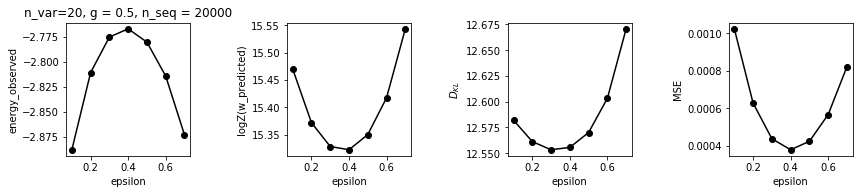

In [11]:
eps = np.linspace(0.1,0.9,9)
cut = -2

nx,ny = 4,1
fig, ax = plt.subplots(ny,nx,figsize=(nx*3,ny*2.8))
ax[0].plot(eps[:cut],energy_av[:cut],'ko-')
ax[1].plot(eps[:cut],logZ[:cut],'ko-')
#ax[1].plot([eps[0],eps[cut-1]],[logZ_true,logZ_true],'r--')

ax[2].plot(eps[:cut],D_KL[:cut],'ko-')
ax[3].plot(eps[:cut],MSE[:cut],'ko-')

for i in range(nx):
    ax[i].set_xlabel('epsilon')

ax[0].set_ylabel('energy_observed')
ax[1].set_ylabel('logZ(w_predicted)')
ax[2].set_ylabel('$D_{KL}$')
ax[3].set_ylabel('MSE')

ax[0].set_title('n_var=%s, g = %s, n_seq = %s'%(n_var,g,n_seq))
plt.tight_layout(h_pad=0.7, w_pad=1.5)
#plt.savefig('fig_M20_g05_N100k.pdf', format='pdf', dpi=100)

## Energy

In [12]:
# unobsered configurations:
def difference_2d_arrays(a1,a2):
    # find the difference between 2d arrays
    a1_rows = a1.view([('', a1.dtype)] * a1.shape[1])
    a2_rows = a2.view([('', a2.dtype)] * a2.shape[1])
    a3 = np.setdiff1d(a1_rows, a2_rows).view(a1.dtype).reshape(-1, a1.shape[1])
    return a3

In [13]:
seq_unobs = difference_2d_arrays(seq_all,seqs)
print(seq_unobs.shape)

ops_unobs = EM.operators(seq_unobs)
print(ops_unobs.shape)

(1039599, 20)
(1039599, 210)


In [14]:
# energy of unobserved configurations as function of eps
energy_unobs = -ops_unobs.dot(w_eps.T)
energy_unobs_av = energy_unobs.mean(axis=0)

ops_all = EM.operators(seq_all)
energy_all = -ops_all.dot(w_eps.T)
energy_all_av = energy_all.mean(axis=0)

In [15]:
# energy of test set
energy_test = -ops_test.dot(w_eps.T)
energy_test_av = energy_test.mean(axis=0)

In [16]:
# random configurations
seq_random = np.random.choice([1.0,-1.0],size=(int(n_seq/2),n_var),replace=True)
print(seq_random.shape)

ops_random = EM.operators(seq_random)
energy_random = -ops_random.dot(w_eps.T)
energy_random_av = energy_random.mean(axis=0)

(10000, 20)


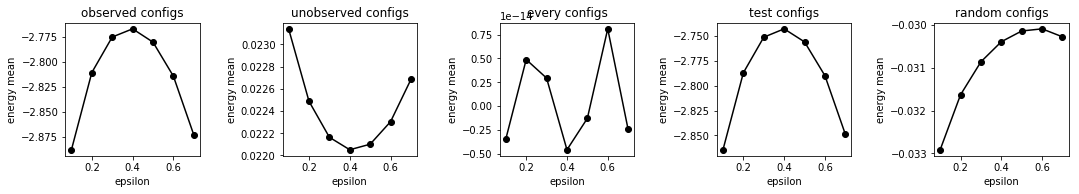

In [17]:
nx,ny = 5,1
fig, ax = plt.subplots(ny,nx,figsize=(nx*3,ny*2.8))

ax[0].plot(eps[:cut],energy_av[:cut],'ko-')
ax[1].plot(eps[:cut],energy_unobs_av[:cut],'ko-')
ax[2].plot(eps[:cut],energy_all_av[:cut],'ko-')
ax[3].plot(eps[:cut],energy_test_av[:cut],'ko-')
ax[4].plot(eps[:cut],energy_random_av[:cut],'ko-')

for i in range(nx):
    ax[i].set_xlabel('epsilon')
    ax[i].set_ylabel('energy mean')

ax[0].set_title('observed configs')
ax[1].set_title('unobserved configs')
ax[2].set_title('every configs')
ax[3].set_title('test configs')
ax[4].set_title('random configs')

plt.tight_layout(h_pad=0.7, w_pad=1.5)

## Histogram of Energy

In [18]:
# optimal eps
i_eps = np.argmax(e_eps)
print(i_eps,eps[i_eps])

3 0.4


### Observed configurations

(9, 10)


Text(0, 0.5, 'histogram')

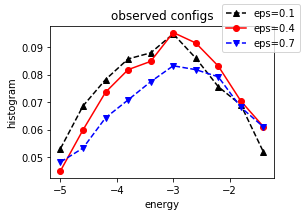

In [19]:
## Histogram of energy of observed configurations
bins = np.linspace(-5.0,-1.0,11,endpoint=True)
bins2 = bins[:-1] #+ 0.03

histo = np.array([np.histogram(energy[:,i],bins)[0]/energy.shape[0] for i in range(len(eps))])
print(histo.shape)

i1 = i_eps - 3
i2 = i_eps + 3

nx,ny = 1,1
fig, ax = plt.subplots(ny,nx,figsize=(nx*4,ny*2.8))

ax.plot(bins2,histo[i1],'k^--',label='eps=%1.1f'%eps[i1])
ax.plot(bins2,histo[i_eps],'ro-',label='eps=%1.1f'%eps[i_eps])
ax.plot(bins2,histo[i2],'bv--',label='eps=%1.1f'%eps[i2])
fig.legend()
ax.set_title('observed configs')

ax.set_xlabel('energy')
ax.set_ylabel('histogram')

### Unobserved configurations

(9, 10)


Text(0, 0.5, 'histogram')

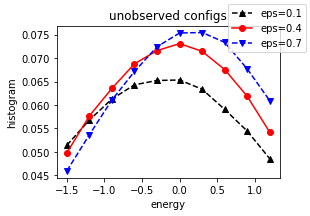

In [20]:
# Histogram of energy of unobserved configurations
bins = np.linspace(-1.5,1.5,11,endpoint=True)
bins2 = bins[:-1] #+ 0.03
histo_unobs = np.array([np.histogram(energy_unobs[:,i],bins)[0]/energy_unobs.shape[0] for i in range(len(eps))])
print(histo_unobs.shape)

i1 = i_eps - 3
i2 = i_eps + 3

nx,ny = 1,1
fig, ax = plt.subplots(ny,nx,figsize=(nx*4,ny*2.8))

ax.plot(bins2,histo_unobs[i1],'k^--',label='eps=%1.1f'%eps[i1])
ax.plot(bins2,histo_unobs[i_eps],'ro-',label='eps=%1.1f'%eps[i_eps])
ax.plot(bins2,histo_unobs[i2],'bv--',label='eps=%1.1f'%eps[i2])
fig.legend()
ax.set_title('unobserved configs')

ax.set_xlabel('energy')
ax.set_ylabel('histogram')

## Entropy

In [21]:
## Entropy of training set as functions of epsilon
prob = np.exp(energy)
prob /= prob.sum(axis=0)[np.newaxis,:]
entropy = -(prob*np.log(prob)).sum(axis=0)

## Entropy of test set as functions of epsilon
prob_test = np.exp(energy_test)
prob_test /= prob_test.sum(axis=0)[np.newaxis,:]
entropy_test = -(prob_test*np.log(prob_test)).sum(axis=0)

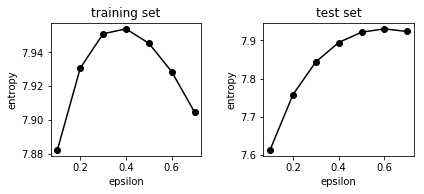

In [22]:
nx,ny = 2,1
fig, ax = plt.subplots(ny,nx,figsize=(nx*3,ny*2.8))
ax[0].plot(eps[:cut],entropy[:cut],'ko-')
ax[1].plot(eps[:cut],entropy_test[:cut],'ko-')

for i in range(nx):
    ax[i].set_xlabel('epsilon')
    ax[i].set_ylabel('entropy')

ax[0].set_title('training set')
ax[1].set_title('test set')

plt.tight_layout(h_pad=0.7, w_pad=1.5)